<a href="https://colab.research.google.com/github/Nataliia5722/AI/blob/main/CNN_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The CIFAR-10 dataset

The **CIFAR-10** dataset consists of 60000 32x32 colour images in __10 classes__, with 6000 images per class. There are 50000 training images and 10000 test images.
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

The dataset is divided into **five** training batches and one __test__ batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.
Classes: airplane, automobile, bird, frog, dog, deer, cat, horse, ship,truck

In [34]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

- `transforms.ToTensor` — Applies a scaling operation of changing range from 0–255 to 0–1. **It converts a PIL Image or numpy ndarray to a tensor (C x H x W) in the range of 0–1.**
- `transforms.Normalize` - Normalizes a tensor image with provided mean and standard deviation. For an image with 3 channels (RGB), 3 values for mean and 3 values for standard deviation are given as parameters(in form of tuple) corresponding to each channel.
- `transforms.Pad` — It pads given image on all sides with the given padding value. If a single integer value is provided for padding parameter then that value is used to pad all borders. 
- `transforms.RandomHorizontalFlip`— Flipping operation helps in changing the orientation of the image. RandomHorizontalFlip changes the orientation horizontally similarly we can use `RandomVerticalFlip` for changing vertical orientation. 
[Transforming data in Pytorch](https://medium.com/analytics-vidhya/transforming-data-in-pytorch-741fab9e008c)

`torchvision.datasets`- all datasets are subclasses of torch.utils.data.Dataset i.e, they have \__getitem__ and \__len__ methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel using torch.multiprocessing workers.

## Loading the train and test data

In [134]:
transform =  transforms.ToTensor()

Another variant of transformation

In [135]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Loading the data into batches to optimize the memory and to avoid running into out-of-memory error.

In [136]:
train_data = datasets.CIFAR10( root = "./data", download=True, train= True, transform= transform)
test_data = datasets.CIFAR10( root = "./data", download=True, train= False, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [137]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [138]:
class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Split on train and validation dataset

In [139]:
torch.manual_seed(43)
val_size = 5000
train_size = len(train_data) - val_size

In [140]:
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [141]:
batch_size=50

In [142]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size*2, num_workers=2, pin_memory=True)

Visualize the images that are loaded using `make_grid` (torchvision.utils.make_grid - make a grid of images.)



In [143]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [144]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

 deer horse  deer  ship horse truck  frog  deer


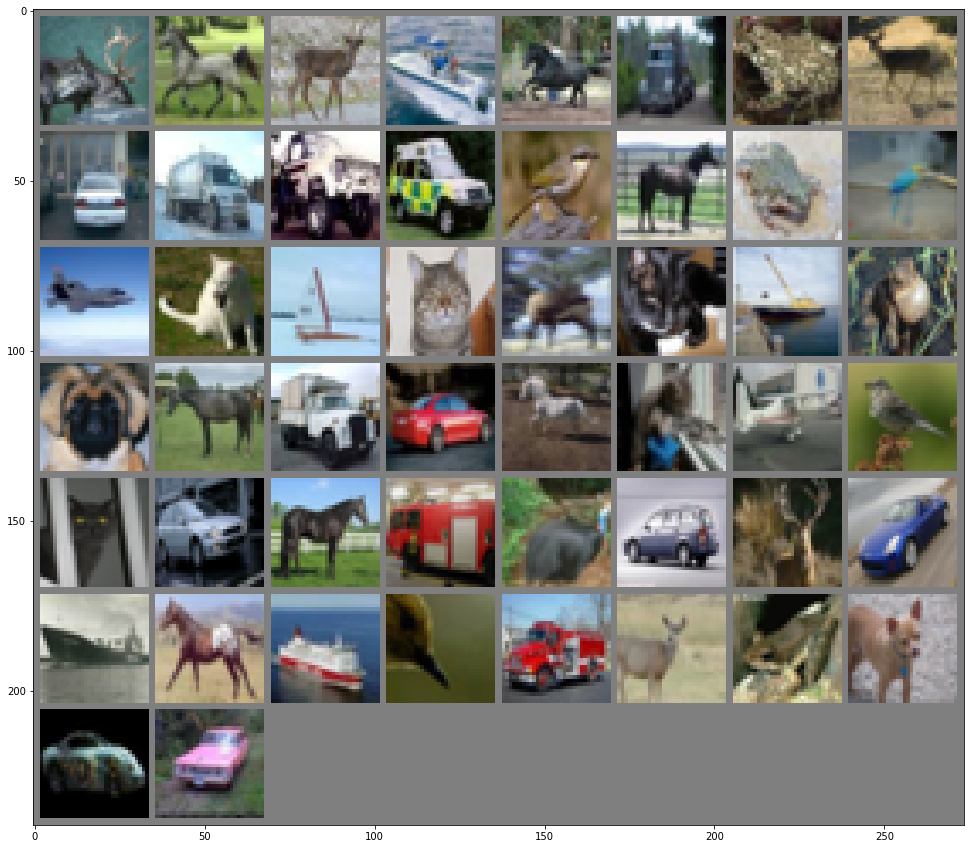

In [145]:
# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([50, 3, 32, 32])


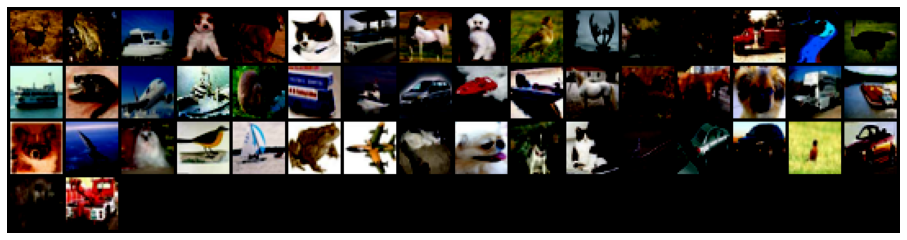

In [146]:
for images, _ in train_loader:
  # images = images / 2 + 0.5  
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [147]:
images.shape

torch.Size([50, 3, 32, 32])

The each image inside batch is fed into model of batch size 100 each. So each batch will have dimension as $100*3*32*32$

In [148]:
for i , (X_train,y_train) in enumerate(train_data):     
    break
x = X_train.view(-1,3,32,32)
x.shape

torch.Size([1, 3, 32, 32])

## Define Model

**The initial layers** of CNN is usually referred to as a `sequential layer`,that are sequences of `convolution layer` + `relu` + `pooling` is placed in sequence. **Second part** of the model is referred to as classification layer which actually does the job of classifying the images into its respective classes.

###Conv2d

CLASStorch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, padding_mode='zeros')

`self.conv1 = nn.Conv2d(3,5,5,1)` - converts the image which is 3 color channel to 5 feature maps with a filter of $5*5$ and stride as 1

In [149]:
conv1 = nn.Conv2d(3,5,5,1)
X  = conv1(x)
X.shape

torch.Size([1, 5, 28, 28])

`torch.nn.MaxPool2d`(kernel_size, stride=None, padding=0)

In [150]:
X = F.max_pool2d(X,2,2)
X.shape

torch.Size([1, 5, 14, 14])

In [151]:
conv2 = nn.Conv2d(5,20,3,1)
X  = conv2(X)
X.shape

torch.Size([1, 20, 12, 12])

In [152]:
X = F.max_pool2d(X,2,2)
X.shape

torch.Size([1, 20, 6, 6])

In [153]:
class convCIFAR(nn.Module):
    def __init__ (self):
      super().__init__()
      self.conv1 = nn.Conv2d(3,5,5,1)  
      self.conv2 = nn.Conv2d(5,20,3,1)         

      self.fc1 = nn.Linear(6*6*20,120)
      self.fc2 = nn.Linear(120,80)
      self.fc3 = nn.Linear(80,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))  
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1,6*6*20)        
           
        x = F.relu(self.fc1(x))    
        x = F.relu(self.fc2(x))  
        x = F.log_softmax(self.fc3(x),dim = 1)    
        return(x)

### Use GPU

In [154]:
torch.cuda.is_available()

True

In [155]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [156]:
device = get_default_device()
device

device(type='cuda')

In [157]:
model=convCIFAR().to(device)

In [158]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Train model

In [159]:
EPOCHS  = 50

train_loss  = np.zeros((EPOCHS,))
train_accuracy = np.zeros((EPOCHS,))
valid_loss = np.zeros((EPOCHS,))
valid_accuracy = np.zeros((EPOCHS,))

In [160]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss[epoch] = loss.item()
        train_correct = (torch.argmax(outputs, dim=1) == labels).type(torch.FloatTensor)
        train_accuracy[epoch] = train_correct.mean()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 1000 mini-batches
            print('[%d, %5d] validation loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    for i, data in enumerate(val_loader, 0):
      inputs_valid, labels_valid = data
      inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
      with torch.no_grad():
        y_pred = model(inputs_valid)
        loss = criterion(y_pred, labels_valid)
        valid_loss[epoch] = loss.item()
        correct = (torch.argmax(y_pred, dim=1) == labels_valid).type(torch.FloatTensor)
        valid_accuracy[epoch] = correct.mean()

print('Finished Training')

Finished Training


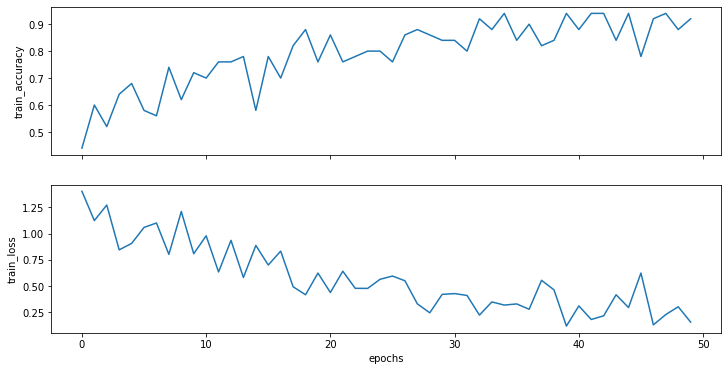

In [161]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_accuracy)
ax1.set_ylabel("train_accuracy")
ax2.plot(train_loss)
ax2.set_ylabel("train_loss")
ax2.set_xlabel("epochs");

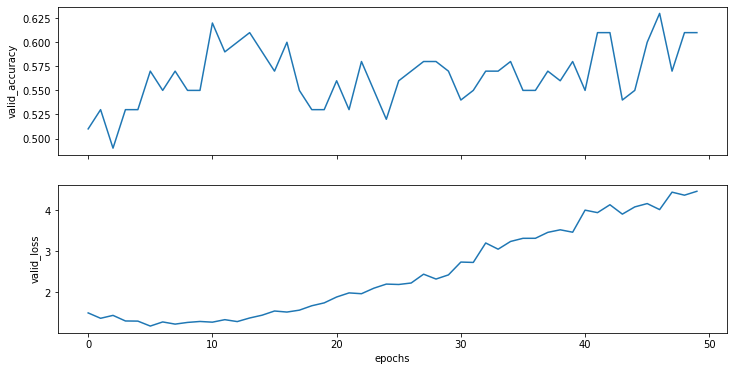

In [162]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(valid_accuracy)
ax1.set_ylabel("valid_accuracy")
ax2.plot(valid_loss)
ax2.set_ylabel("valid_loss")
ax2.set_xlabel("epochs");

## Evaluate model

In [163]:
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs_test, labels_test = data
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs = model(inputs_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_test.size(0)
        correct += (predicted == labels_test).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))    

Accuracy of the network on the 10000 test images: 57 %


In [164]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in test_loader:
    inputs_test, labels_test = data
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    outputs = model(inputs_test)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels_test).squeeze()
    for i in range(4):
        label = labels_test[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 72 %
Accuracy of automobile : 75 %
Accuracy of  bird : 44 %
Accuracy of   cat : 44 %
Accuracy of  deer : 48 %
Accuracy of   dog : 46 %
Accuracy of  frog : 62 %
Accuracy of horse : 71 %
Accuracy of  ship : 60 %
Accuracy of truck : 48 %


In [165]:
PATH = 'sample_data/cefar10_net.pth'
torch.save(model.state_dict(), PATH)

После изменения некоторых парамметров (batch, epochs и трансформации) можно сделать вывод, что в случае при batch=50 и epochs=50, хоть accuracy для 10000 тестовых картинок стала немного меньше, но в это же время accuracy для классов airplane и automobile, frog возросла